# Script for verifying model output against Snell's law
With and without ambient currents

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import xarray as xa
import scipy.ndimage as sn

import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))

from ocean_wave_tracing import Wave_tracing

%matplotlib inline

## Create domain

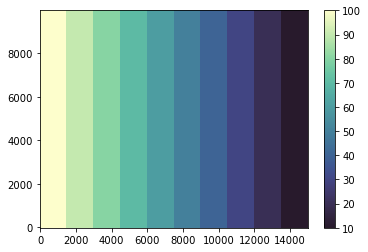

In [2]:
dx=dy=50 #m

nny, nnx = (200,300)
xx = np.arange(nnx)*dx
yy = np.arange(nny)*dy

xx_bat, yy_bat=np.meshgrid(np.linspace(1,0,nny),np.linspace(1,0,nnx))

depth_max = 100
depth_min = 10

depth_profile = np.arange(depth_min,depth_max+depth_min,depth_min)[::-1]
indicices_increment = int(nnx/depth_profile.size) 

bathymetry = np.ones((nny,nnx))

for j,i in enumerate(range(0,nnx,indicices_increment)):
    upper_limit = i+indicices_increment
    bathymetry[:,i:upper_limit] = depth_profile[j]
    
# Zero currents
zero_current = np.zeros((nny,nnx))

bathymetry_smooth=sn.filters.gaussian_filter(bathymetry,sigma=2)

fig,ax = plt.subplots(nrows=1,ncols=1)

pc0 = ax.pcolormesh(xx,yy,bathymetry,cmap=cmocean.cm.deep_r, shading='auto')
cbar = plt.colorbar(pc0)

## Defining a shallow water wave

In [7]:
def is_shallow_water(d,lambd):
    """ Test if a wave can be defined as a shallow water wave
    """
    print(d/lambd)
    if d/lambd <= 0.04:
        return True
    else:
        return False
    
lambd = 10000 # wave length

if is_shallow_water(d=depth_max,lambd=lambd):
    wave_period = lambd/np.sqrt(9.81*depth_max)
    
    print(wave_period)

0.01
319.27542840705047


## Solve the wave ray equations

In [5]:
# SET conditions for wave tracing
nb_wave_rays = 1#nx
T = 600
nt = 2000
#i_w_side = 'left'
theta0 = np.pi/8

X0, XN = xx[0], xx[-1]
Y0, YN = yy[0], yy[-1]
ipx=float(xx[0])
ipy = float(0.5*YN-Y0)

In [8]:
wt_z = Wave_tracing(U=zero_current, V=zero_current, 
                      nx=nnx, ny=nny,
                      nt=nt,T=T,
                      dx=dx,
                      dy=dy,
                      nb_wave_rays=nb_wave_rays,
                      domain_X0=X0, domain_XN=XN,
                      domain_Y0=Y0, domain_YN=YN,                      
                      temporal_evolution=False, d=bathymetry,
                      DEBUG=False)
wt_z.set_initial_condition(wave_period=wave_period, theta0=theta0,
                           ipx=ipx,ipy=ipy)#incoming_wave_side=i_w_side)
wt_z.solve()

## Snell's law
$$
\frac{sin(\theta_1)}{sin(\theta_2)} = \frac{c_1}{c_2} \\
$$



In [9]:
ray_id = 0
idt0=0

c1 = wt_z.ray_cg[ray_id,idt0]
theta_1 = wt_z.ray_theta[ray_id,idt0]

c2 = wt_z.ray_cg[ray_id,-4]

theta_2 = np.arcsin((c2/c1) * np.sin(theta_1))
theta_2 %= (2*np.pi) # for negative angles

diff = theta_2 - wt_z.ray_theta[ray_id,-2] 
print('Difference theory vs. model: {} degrees.'.format(np.round(diff*(180/np.pi),3)))
print('Difference percentage: {}%.'.format(np.round((diff*(180/np.pi))/theta_2,3)))
#np.tanh(wt_z.k[ray_id,0]*wt_z.d.values[ray_id,0]), c2/c1

Difference theory vs. model: -0.035 degrees.
Difference percentage: -0.204%.


In [10]:
# find all wave celerity regimes
indices =  np.array([i for i in range(int(0.5*indicices_increment),nnx-int(0.5*indicices_increment),indicices_increment)])
ray_x_indices = [np.argmin(np.abs(wt_z.ray_x-wt_z.x[i])) for i in indices]

#print(wt_z.ray_cg[0,ray_x_indices])
#print(wt_z.ray_theta[0,ray_x_indices])

In [11]:
analytical_theta1s = []
analytical_theta2s = []
analytical_c1s = []
analytical_c2s = []

for i in range(len(ray_x_indices)-1):
    t1 = wt_z.ray_theta[ray_id,ray_x_indices[i]]
    if i == 0:
        analytical_theta2s.append(t1) # for comparison with model output
    c1 = wt_z.ray_cg[ray_id,ray_x_indices[i]]
    c2 = wt_z.ray_cg[ray_id,ray_x_indices[i+1]]
    
    t2 = np.arcsin((c2/c1) * np.sin(t1))
    t2 %= (2*np.pi) # for negative angles
    
    analytical_theta1s.append(t1)
    analytical_theta2s.append(t2)
    analytical_c1s.append(c1)
    analytical_c2s.append(c2)
    
    

In [12]:
ddiff = analytical_theta2s-wt_z.ray_theta[ray_id,ray_x_indices]
ddiff_degs = np.round(ddiff*(180/np.pi),3)
ddiff_perc = np.round(np.abs(((analytical_theta2s-wt_z.ray_theta[ray_id,ray_x_indices])/analytical_theta2s)*100),3)

print('Difference theory vs. model: {} degrees.'.format(ddiff_degs))
print('Difference percentage: {}%.'.format(ddiff_perc))

Difference theory vs. model: [ 0.     0.021  0.063 -0.005  0.008 -0.002 -0.048 -0.058  0.004] degrees.
Difference percentage: [0.0 0.099 0.317 0.027 0.049 0.011 0.342 0.475 0.04]%.


In [14]:
#print(ddiff_degs)
#print(analytical_theta2s)
#print(wt_z.ray_theta[ray_id,ray_x_indices])

In [15]:
#print(((analytical_theta2s-wt_z.ray_theta[ray_id,ray_x_indices])/analytical_theta2s)*100)

# With ambient current

In [16]:
V = np.zeros((nny,nnx))
current_speed = 2#1.5#[m/s]
V[:,40::] = current_speed
theta0_v = float(np.deg2rad(50))#np.pi/4

wave_period_v = 10


wt_v = Wave_tracing(U=zero_current, V=V, 
                      nx=nnx, ny=nny,
                      nt=nt,T=T,
                      dx=dx,
                      dy=dy, 
                      nb_wave_rays=nb_wave_rays,
                      domain_X0=X0, domain_XN=XN,
                      domain_Y0=Y0, domain_YN=YN,                      
                      temporal_evolution=False, d=None,
                      DEBUG=False)
wt_v.set_initial_condition(wave_period=wave_period_v, theta0=theta0_v,ipx=ipx,ipy=ipy)
wt_v.solve()

## Snell's law after Jonsson
$$
sin(\alpha_2)= \frac{sin(\alpha_1)}{(1- \frac{u}{c} sin(\alpha_1))^2} \\
$$


In [17]:
def snells_law_current(alpha_1, U, c0):
    rhs = ((np.sin(alpha_1)) / (1 - (U/c0) * np.sin(alpha_1))**2)
    print(U/c0, rhs)
    alpha_2 = np.arcsin(rhs )
    return alpha_2

In [22]:
alpha_1 =  theta0_v
c = wt_v.c_intrinsic(wt_v.ray_k[ray_id,idt0],d=1e5,group_velocity=False)

rhs = ((np.sin(alpha_1)) / (1 - (current_speed/c) * np.sin(alpha_1))**2)

alpha_2 = np.arcsin(rhs)
alpha_2=snells_law_current(alpha_1=alpha_1,U=current_speed,c0=c)

wt_v.ray_theta[ray_id,-1]

diff_v = alpha_2 - wt_v.ray_theta[ray_id,-1] 
diff_v_deg = np.round(diff_v*(180/np.pi),3)
diff_v_perc = np.round(((np.abs((alpha_2 - wt_v.ray_theta[ray_id,-1])/alpha_2))*100),3)
print('Difference theory vs. model: {} degrees.'.format(diff_v_deg))
print('Difference percentage: {}%.'.format(diff_v_perc))

0.12809755977940032 0.9418127535998623
Difference theory vs. model: 0.403 degrees.
Difference percentage: 0.573%.


In [23]:

alpha_2

1.2279830769458548

In [25]:
fs=14
fig,ax = plt.subplots(nrows=2,sharex=True,sharey=True,figsize=(12,8))
 
pc=ax[0].pcolormesh(wt_z.x,wt_z.y,-wt_z.d,shading='auto',cmap=cmocean.cm.deep_r,
                         vmin=-110,vmax=0)
    

ax[0].plot(wt_z.ray_x[:,0],wt_z.ray_y[:,0],'o')
ax[0].plot(wt_z.ray_x[0,:],wt_z.ray_y[0,:],'-k',
        lw=3,alpha=1,label='Wave ray')
ax[0].plot(wt_z.ray_x[0,ray_x_indices[1::]],wt_z.ray_y[0,ray_x_indices[1::]],
        marker='s',ms=10,ls='None',alpha=1,c='tab:red')

for j,i in enumerate(ray_x_indices[1::]):
    ax[0].text(wt_z.ray_x[0,i],wt_z.ray_y[0,i]+500,
            r'$\phi_2=${}$^\circ$'.format(np.round(analytical_theta2s[j+1]*(180/np.pi),2)),horizontalalignment='center',
            fontsize=fs-4,c='1')

    ax[0].text(wt_z.ray_x[0,i],wt_z.ray_y[0,i]-700,
            r'$\Delta=${}%'.format(ddiff_perc[j+1]),horizontalalignment='center',
            fontsize=fs-4,c='1')

    
pc2=ax[1].pcolormesh(wt_v.x,wt_v.y,wt_v.V.isel(time=0),shading='auto',cmap=cmocean.cm.speed,vmin=0,vmax=3)
jump=30
ax[1].quiver(wt_v.x[::jump], wt_v.y[::jump], 
          wt_v.U.isel(time=0)[::jump,::jump],
          wt_v.V.isel(time=0)[::jump,::jump],color='k',scale=35)

    

ax[1].plot(wt_v.ray_x[:,0],wt_v.ray_y[:,0],'o')
ax[1].plot(wt_v.ray_x[0,:],wt_v.ray_y[0,:],'-r',lw=4,alpha=1,label='Wave ray')        

ax[1].text(2200,7200,
            r'$\Delta=${}%'.format(diff_v_perc),horizontalalignment='left',
            fontsize=fs-2,c='1')
    
ax[1].set_xlabel('[m]',fontsize=fs)
ax[1].set_ylabel('[m]',fontsize=fs)
    

ax[0].set_xlim([wt_z.domain_X0,wt_z.domain_XN])
ax[0].set_ylim([2000,wt_z.domain_YN])
ax[0].set_ylabel('[m]',fontsize=fs)

fig.tight_layout()

cb = fig.colorbar(pc,ax=ax[0])
cb.set_label('Depth [m]',fontsize=fs)
cb.ax.tick_params(labelsize=fs-2) 

cb1 = fig.colorbar(pc2)
cb1.set_label(r'$V(x)$ [m/s]',fontsize=fs)
cb1.ax.tick_params(labelsize=fs-2) 



for aax in ax.flatten():
    aax.tick_params(labelsize=fs)
    aax.legend(fontsize=fs,loc='lower right')

#fig.savefig('snells_law_bath_and_current.png',dpi=120)
plt.close(fig)